This notebook is a tutorial for performing domain adaptation between scATAC and scRNA SEACells.

# Imports

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Some plotting aesthetics
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100

In [ ]:
def log_transform(ad, ps=0.1):
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)


# Load Data

We recommend the use of scanpy Anndata objects as the preferred mode of loading and filtering data.

A sample datset is available for download with the instructions listed below. TODO: Upload the summarized SEACell anndata objects to S3.

Uncomment the following lines to download the sample dataset in a Unix-based system. For non-UNIX systems, download the files using the URL



In [4]:
# !mkdir data/
# !wget https://dp-lab-data-public.s3.amazonaws.com/SEACells/cd34_multiome_rna_with_labels.h5ad -O data/cd34_multiome_rna_with_labels.h5ad
# !wget https://dp-lab-data-public.s3.amazonaws.com/SEACells/cd34_multiome_atac_with_labels.h5ad -O data/cd34_multiome_atac_with_labels.h5ad

In [92]:
# Load the data using scanpy

rna_ad = sc.read(f'data/cd34_multiome_rna_with_labels.h5ad')

from SEACells.core import summarize_by_SEACell
rna_meta_ad = summarize_by_SEACell(rna_ad, SEACells_label='SEACell')

In [83]:
rna_meta_ad.obs['celltype'] = rna_ad.obs.groupby('SEACell').apply(lambda x: pd.Series(x['celltype']).mode())#%%

/Users/sitarapersad/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2492: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/sitarapersad/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2492: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [ ]:
sc.pp.normalize_per_cell(rna_meta_ad, counts_per_cell_after=10000)
log_transform(rna_meta_ad)

sc.pp.highly_variable_genes(rna_meta_ad)

sc.tl.pca(rna_meta_ad, n_comps=50, use_highly_variable=True)
sc.pp.neighbors(rna_meta_ad)
sc.tl.umap(rna_meta_ad)

In [ ]:
%matplotlib inline
# Plot cell-types for reference
sc.pl.scatter(rna_meta_ad, basis='umap', color='celltype', frameon=False)

# ATAC-seq gene scores

We use the gene scores derived from archR aggregated by SEACell.

In [87]:
atac_ad = sc.read(f'data/cd34_multiome_atac_with_labels.h5ad')

(82,)

In [96]:
genescores = pd.DataFrame(atac_ad.obsm['GeneScores'])
genescores.columns = rna_meta_ad.var_names
genescores.index = atac_ad.obs_names

genescores = genescores.join(atac_ad.obs['SEACell']).groupby('SEACell').sum()

/Users/sitarapersad/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2492: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


In [97]:
import anndata
atac_meta_ad = anndata.AnnData(genescores)
atac_meta_ad.obs = atac_ad.obs.loc[atac_meta_ad.obs_names]

In [100]:
from scipy.sparse import csr_matrix
atac_meta_ad.X = csr_matrix(atac_meta_ad.X)

In [101]:
atac_meta_ad.to_df()

,LINC01128,FAM41C,NOC2L,ISG15,AGRN,C1orf159,SDF4,B3GALT6,UBE2J2,SCNN1D,...,MPP1,F8,FUNDC2,CMC4,MTCP1,BRCC3,VBP1,RAB39B,CLIC2,TMLHE
Metacell,,,,,,,,,,,,,,,,,,,,,
cd34_multiome_rep1#AAACAGCCACTCGCTC-1,0.0,0.433000,0.643000,0.673000,0.000000,0.377000,1.285000,2.307000,0.000000,0.000000,...,0.916,0.000000,0.000000,1.520000,0.788000,0.871000,0.0,0.0,0.000000,0.000
cd34_multiome_rep1#AAAGCAAGTATTTGCC-1,0.0,3.431000,13.328000,34.000999,46.369999,17.483000,13.461000,24.156000,17.591000,9.778000,...,0.414,2.527000,3.466000,14.300000,7.410000,8.188000,0.0,0.0,2.895000,0.000
cd34_multiome_rep1#ACCAAACTCGCTATAA-1,0.0,6.902000,7.761000,33.348999,42.327999,23.163000,15.381000,27.606001,14.425000,5.114000,...,0.000,4.156000,5.700000,11.051000,5.725000,6.327000,0.0,0.0,2.464000,0.000
cd34_multiome_rep1#ACCCTCCCAACCGCCA-1,0.0,9.925000,18.381001,66.513000,68.625000,37.199001,36.938999,66.296997,42.445000,8.694000,...,7.949,10.806000,14.827000,24.830999,12.865000,14.218000,0.0,0.0,1.790000,0.213
cd34_multiome_rep1#ACGTCAAGTTGCTGGG-1,0.0,43.737000,57.870998,189.406998,223.938004,101.638000,105.105003,188.623993,90.950996,34.854000,...,12.016,34.566002,47.417999,67.401001,34.922001,38.594002,0.0,0.0,22.113001,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cd34_multiome_rep2#TGAACAGAGCTACTGG-1,0.0,8.189000,20.924999,41.743999,82.884003,23.643999,30.697001,55.095001,37.778000,13.233000,...,1.425,8.855000,11.568000,16.495001,8.547000,9.445000,0.0,0.0,1.493000,0.000
cd34_multiome_rep2#TGCATGAGTTGGCCGA-1,0.0,6.558000,19.941999,40.436001,95.616997,43.520000,28.666000,51.445999,45.577000,11.846000,...,5.836,8.630000,11.626000,20.275000,10.503000,11.607000,0.0,0.0,7.927000,0.141
cd34_multiome_rep2#TGGGCATGTGCTTACT-1,0.0,5.837000,12.755000,47.939999,67.989998,27.999001,17.252001,30.959999,56.980000,18.587000,...,2.077,9.009000,9.515000,39.173000,20.295000,22.430000,0.0,0.0,9.631000,0.000


In [102]:
sc.pp.normalize_per_cell(atac_meta_ad, counts_per_cell_after=10000)
log_transform(atac_meta_ad)

sc.tl.pca(atac_meta_ad, n_comps=50)

,LINC01128,FAM41C,NOC2L,ISG15,AGRN,C1orf159,SDF4,B3GALT6,UBE2J2,SCNN1D,...,MPP1,F8,FUNDC2,CMC4,MTCP1,BRCC3,VBP1,RAB39B,CLIC2,TMLHE
Metacell,,,,,,,,,,,,,,,,,,,,,
cd34_multiome_rep1#AAACAGCCACTCGCTC-1,0.0,0.433,0.643,0.673,0.000,0.377,1.285,2.307,0.000,0.000,...,0.916,0.000,0.000,1.520,0.788,0.871,0.0,0.0,0.000,0.000
cd34_multiome_rep1#AAAGCAAGTATTTGCC-1,0.0,3.431,13.328,34.001,46.370,17.483,13.461,24.156,17.591,9.778,...,0.414,2.527,3.466,14.300,7.410,8.188,0.0,0.0,2.895,0.000
cd34_multiome_rep1#ACCAAACTCGCTATAA-1,0.0,6.902,7.761,33.349,42.328,23.163,15.381,27.606,14.425,5.114,...,0.000,4.156,5.700,11.051,5.725,6.327,0.0,0.0,2.464,0.000
cd34_multiome_rep1#ACCCTCCCAACCGCCA-1,0.0,9.925,18.381,66.513,68.625,37.199,36.939,66.297,42.445,8.694,...,7.949,10.806,14.827,24.831,12.865,14.218,0.0,0.0,1.790,0.213
cd34_multiome_rep1#ACGTCAAGTTGCTGGG-1,0.0,43.737,57.871,189.407,223.938,101.638,105.105,188.624,90.951,34.854,...,12.016,34.566,47.418,67.401,34.922,38.594,0.0,0.0,22.113,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cd34_multiome_rep2#TGAACAGAGCTACTGG-1,0.0,8.189,20.925,41.744,82.884,23.644,30.697,55.095,37.778,13.233,...,1.425,8.855,11.568,16.495,8.547,9.445,0.0,0.0,1.493,0.000
cd34_multiome_rep2#TGCATGAGTTGGCCGA-1,0.0,6.558,19.942,40.436,95.617,43.520,28.666,51.446,45.577,11.846,...,5.836,8.630,11.626,20.275,10.503,11.607,0.0,0.0,7.927,0.141
cd34_multiome_rep2#TGGGCATGTGCTTACT-1,0.0,5.837,12.755,47.940,67.990,27.999,17.252,30.960,56.980,18.587,...,2.077,9.009,9.515,39.173,20.295,22.430,0.0,0.0,9.631,0.000


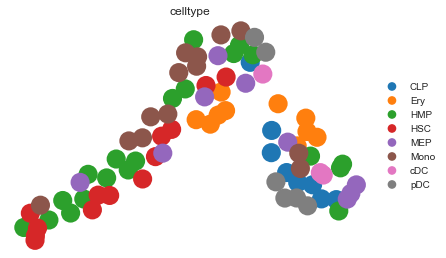

In [15]:
sc.pp.neighbors(atac_meta_ad, use_rep='X_pca')
sc.tl.umap(atac_meta_ad)
sc.pl.scatter(atac_meta_ad, basis='umap', color='celltype', frameon=False)

In [16]:
common = atac_meta_ad.var_names.intersection(rna_meta_ad.var_names)
hvg = rna_meta_ad.var_names[rna_meta_ad.var['highly_variable']].intersection(common)

# Dataset 
atac_meta_ad.obs['Dataset'] = 'ATAC'
rna_meta_ad.obs['Dataset'] = 'RNA'

In [30]:
comb_ad = rna_meta_ad[:, hvg].concatenate(atac_meta_ad[:, hvg], index_unique=None)

/Users/sitarapersad/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2492: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [31]:
# PCA 
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=30)
comb_ad.obsm['X_pca'] = svd.fit_transform(comb_ad.X)

# Domain Adaption

Inputs are

- xs, a matrix of "source" RNA expression levels from scRNA-seq
- xt, a matrix of "target" gene activities calcualated from ATAC-seq peak accessibility


NUmber of metacells irrelevant, # cols the same

Also, optionally:

- ws: vector of weights representing the size of each cluster/metacell from RNA
- wt: same as above but for ATAC
- rho: float in range [0,1] representing whether the final transformation should be closer to RNA distribution (0) or ATAC distribution (1). Default value is 1.
- reg: small float to make sure covariance matrices are invertible

In [32]:
xs = comb_ad[comb_ad.obs['Dataset'] == 'RNA'].obsm['X_pca']
xt = comb_ad[comb_ad.obs['Dataset'] == 'ATAC'].obsm['X_pca']

In [33]:
from SEACells.domainadapt import LinearOT

model = LinearOT()

xs_transformed, xt_transformed = model.fit_transform(xs, xt)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [34]:
comb_ad.obsm['X_pca_transformed'] = pd.DataFrame(xs_transformed).append(pd.DataFrame(xt_transformed)).values

# Mapping ATAC SEACells to RNA SEACellss

In [38]:
# Mapping ATAC SEACells to RNA SEACellss
rna_PCs = pd.DataFrame(xs_transformed)
atac_PCs = pd.DataFrame(xt_transformed)

rna_PCs.index = rna_meta_ad.obs_names
atac_PCs.index = atac_meta_ad.obs_names


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
cd34_multiome_rep2#CGCAATGTCAGCCAAT-1,95.459912,-16.541828,-3.624709,-0.675998,0.447125,1.525751,2.309871,-2.583755,1.783935,2.100463,...,0.058690,0.387334,1.394952,0.828647,-0.027088,2.641964,0.390308,0.683808,0.385090,0.109630
cd34_multiome_rep2#CATTCCTCACCCACAG-1,103.331193,-15.509063,5.893337,-0.320930,-5.036056,1.109094,-1.066245,3.228350,-1.362903,-5.274818,...,1.103932,-1.924408,0.324839,1.710580,-0.648852,-0.270548,-0.252912,0.414493,1.082438,0.159739
cd34_multiome_rep2#CATAAGCTCATTGACA-1,102.019017,-13.822754,-4.912746,-4.806500,0.970492,-0.774854,3.935267,-1.337618,0.022962,3.663745,...,-2.184185,1.596930,-1.466667,-0.640056,-0.158712,-1.291744,-0.936348,1.469094,2.145099,0.499934
cd34_multiome_rep2#CAATCGCCACGTAAGG-1,103.790018,-15.997908,-2.353669,-4.898020,1.884458,0.535364,-1.850098,-0.528812,0.597362,0.383305,...,0.181494,3.536670,-0.997293,0.515939,-0.141044,0.298509,0.502732,0.296638,0.092273,-0.132468
cd34_multiome_rep1#CCAAGTTAGGACCTCA-1,94.349333,-12.696665,-12.797217,7.445460,-1.779180,-1.300148,7.017005,-1.568988,-2.008066,8.959793,...,0.983777,-4.616503,2.116357,-0.325870,-0.734951,0.619098,-0.711212,-3.711041,-0.935153,-0.274197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cd34_multiome_rep1#TGGTAAACACTAAGCC-1,97.885584,-16.201699,4.381795,0.748290,5.905801,3.890993,7.910566,-2.054750,-1.663267,-2.971357,...,-3.071016,1.852144,-2.531168,-3.319251,0.365155,-2.603656,0.854777,1.180858,-1.476996,0.812205
cd34_multiome_rep1#CAAGGCCTCGCTAGAT-1,99.154529,-14.150403,-10.805018,1.465781,2.163320,0.202958,1.336516,-2.723071,0.873853,8.034753,...,-1.492316,0.907127,-1.092958,-1.502718,0.427093,-0.405814,0.885003,1.376551,0.335444,-0.243591
cd34_multiome_rep2#AGTCAATGTACGCGCA-1,99.181606,-16.971983,10.161819,5.541175,2.329735,-2.622035,4.103996,-1.570800,0.032631,-6.629810,...,-0.857397,-2.736967,-0.179592,-2.477114,0.868078,-2.248959,-1.656567,0.082047,-2.521380,1.725724
cd34_multiome_rep2#ACACCTTGTTGTTGCT-1,94.337452,-15.515618,-5.327558,-1.935061,-1.043515,1.515427,9.292459,-2.840286,0.469734,2.962463,...,1.555533,2.144627,1.090975,1.539826,-0.293865,1.663135,0.494072,-0.498440,-0.331594,-0.482859


In [56]:
def compute_distances(df1, df2):
    result = pd.DataFrame(np.zeros((df1.shape[0],df2.shape[0]))).set_index(df1.index)
    result.columns = df2.index

    for mc1, row1 in df1.iterrows():
        for mc2, row2 in df2.iterrows():
            result.loc[mc1, mc2] = np.sqrt(((row1-row2)**2).sum())

    return result

def get_match_ranks(t,k=5):
    """
    Compute mutually ranked metacell matches.
    """
    arr = t.values.T
    ind = np.argsort(arr, axis=0)[:k].T

    df = pd.DataFrame(t.columns.values[ind])
    df.index = t.index
    
    return df

def MNN(rna_PCs, atac_PCs, k=3):
    """
    Construct a mapping between RNA and ATAC SEACells, if an RNA SEACell and 
    ATAC SEACell are mutually in each others' k-nearest neighbors.
    
    Nearest neighbors are computed based on distance in transformed PC space,
    following domain adaption by optimal transport.
    """
    
    # Compute distances between PCs in each data set
    dists = compute_distances(rna_PCs, atac_PCs)
    
    # Find the top k nearest neighbors in each row of the distance matrix
    r1 = get_match_ranks(dists, k)
    r2 = get_match_ranks(dists.T, k)
    # Add edges between samples if they appear in each others top-ranks 

    edges = []
    for index, row in r1.iterrows():
        for nbr in row.values:
            if index in r2.loc[nbr].values:
                edges.append((index, nbr))

    edges = pd.DataFrame(edges)
    edges.columns = ['RNA', 'ATAC']
    return edges

In [62]:
mapping = MNN(rna_PCs, atac_PCs)
mapping.head()

,RNA,ATAC
0,cd34_multiome_rep2#CGCAATGTCAGCCAAT-1,cd34_multiome_rep2#GGTCAAGCAGCACGAA-1
1,cd34_multiome_rep2#CGCAATGTCAGCCAAT-1,cd34_multiome_rep1#TTTGCATTCCCTGTTA-1
2,cd34_multiome_rep2#CATTCCTCACCCACAG-1,cd34_multiome_rep1#GGCGGTAAGTAGCGGG-1
3,cd34_multiome_rep2#CATTCCTCACCCACAG-1,cd34_multiome_rep2#AGGATGTCACCAACCG-1
4,cd34_multiome_rep2#CATTCCTCACCCACAG-1,cd34_multiome_rep1#GCCATGATCCTCCATA-1
